# **(Data Cleaning-Split Data)**

## Objectives

* Double check correlation analysis using custom function from walkthrough 02

* Drop EnclosedPorch and WoodDeckSF

* Split data into cleaned Test and Train sets.

## Inputs

* outputs/datasets/collection/original_no_nan.csv

## Outputs

* outputs/datasets/cleaned/TrainSetCleaned.csv

* outputs/datasets/cleaned/TestSetCleaned.csv

## Additional Comments

* Majority of cleaning already done at this point and distributions assesed in previous books.  


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues'

## Load Data

In [4]:
import pandas as pd

df_original = pd.read_csv("outputs/datasets/collection/original_no_nan.csv")

df_original.head(5)
print(df_original.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   1stFlrSF       1460 non-null   int64  
 1   2ndFlrSF       1460 non-null   int64  
 2   BedroomAbvGr   1460 non-null   int64  
 3   BsmtExposure   1460 non-null   object 
 4   BsmtFinSF1     1460 non-null   int64  
 5   BsmtFinType1   1460 non-null   object 
 6   BsmtUnfSF      1460 non-null   int64  
 7   EnclosedPorch  1460 non-null   int64  
 8   GarageArea     1460 non-null   int64  
 9   GarageFinish   1460 non-null   object 
 10  GarageYrBlt    1460 non-null   float64
 11  GrLivArea      1460 non-null   int64  
 12  KitchenQual    1460 non-null   object 
 13  LotArea        1460 non-null   int64  
 14  LotFrontage    1460 non-null   float64
 15  MasVnrArea     1460 non-null   float64
 16  OpenPorchSF    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  OverallQ

- GarageYrBlt still has a type of float.

- There are no nan values


---

In [5]:
df_original.columns.unique()

Index(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1',
       'BsmtFinType1', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea',
       'GarageFinish', 'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea',
       'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond',
       'OverallQual', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd',
       'SalePrice'],
      dtype='object')

- Double check the categorical variables unique counts.

    - These will be ordinal encoded in the feature engineering book

In [6]:
print(tuple(df_original['BsmtExposure'].unique()))
print(tuple(df_original['BsmtFinType1'].unique()))
print(tuple(df_original['GarageFinish'].unique()))
print(tuple(df_original['KitchenQual'].unique()))

('No', 'Gd', 'Mn', 'Av', 'None')
('GLQ', 'ALQ', 'Unf', 'Rec', 'None', 'BLQ', 'LwQ')
('RFn', 'Unf', 'None', 'Fin')
('Gd', 'TA', 'Ex', 'Fa')


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [9]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df_original)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.049  0.098  0.0  0.0  0.0  0.055  0.625


- I Used the custom function here from the walkthrough 02 to see if it showed up anything different.

- It tells a very similar story as the previous notebook analysis.



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



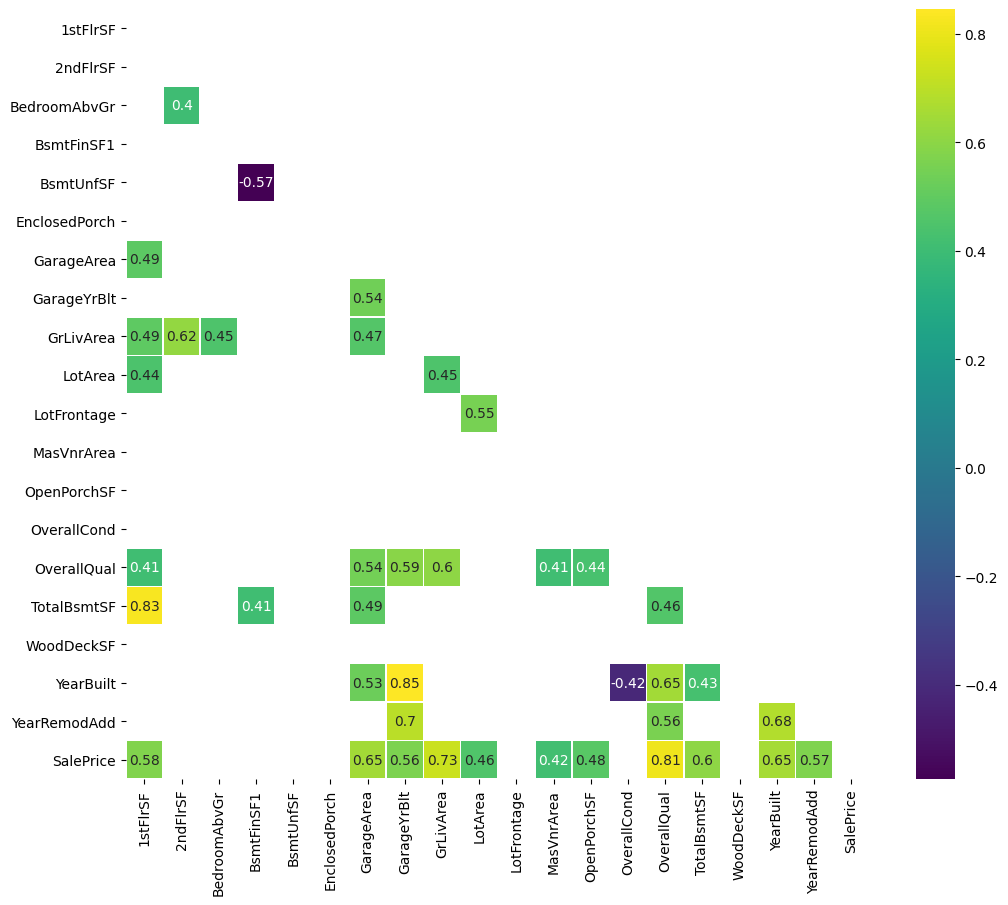



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



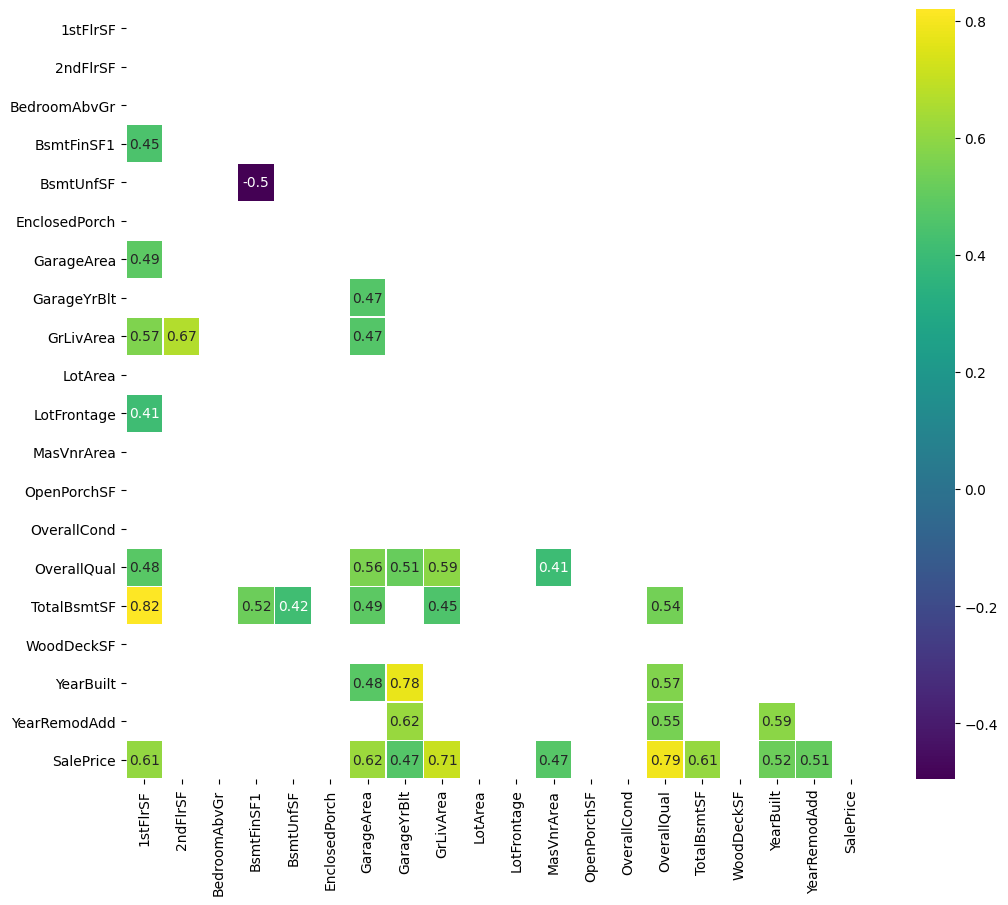



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



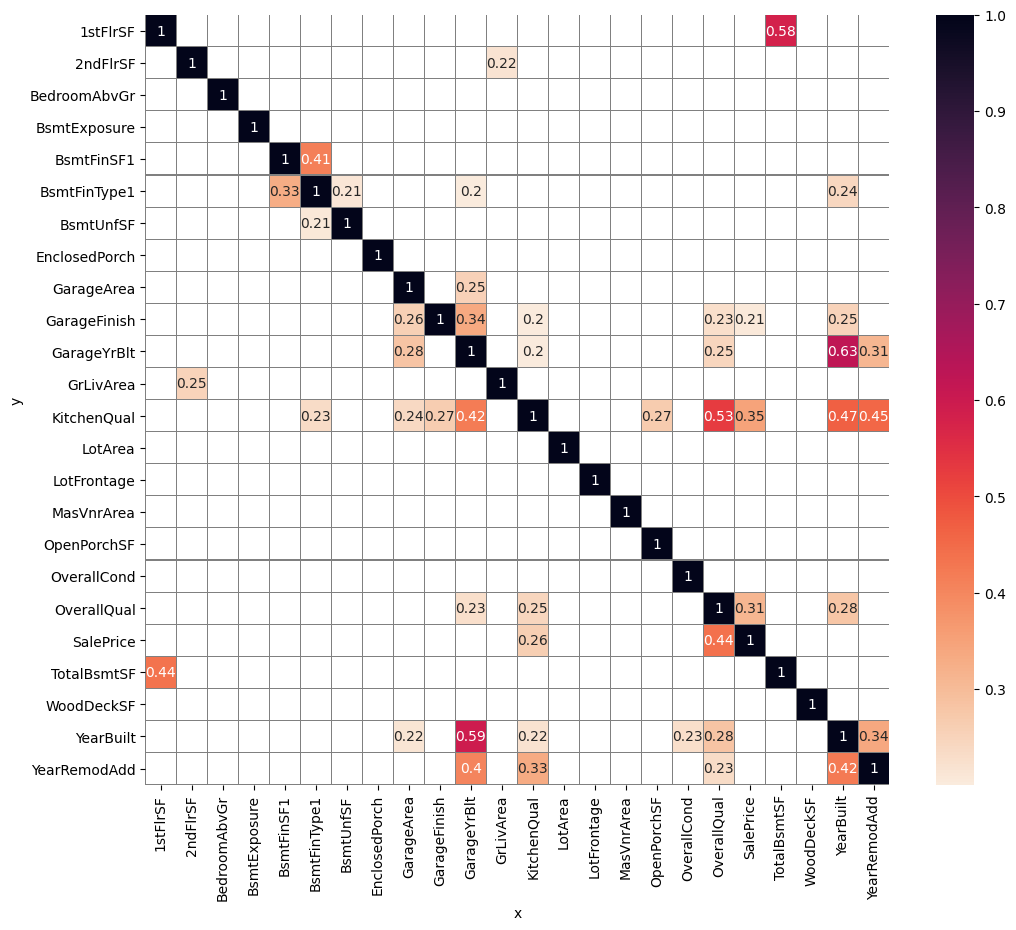

In [10]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

## Split Data to Train and Test Sets

In [11]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df_original,
                                        df_original['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


In [12]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

In [13]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 0 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType


---

## Drop Variables

- Dropping these variables as zero values make up almost 90% of the values in these columns.

In [14]:
variables_method = ['EnclosedPorch', 'WoodDeckSF']

print(f"* {len(variables_method)} variables to drop \n\n"
    f"{variables_method}")

* 2 variables to drop 

['EnclosedPorch', 'WoodDeckSF']


In [15]:
# Drop features and Transform Test set
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)

In [16]:
# Fit Test set and transform Test set.
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)

TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

In [17]:
print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 22) 
TestSet shape: (292, 22)


In [18]:
EvaluateMissingData(TrainSet)

,RowsWithMissingData,PercentageOfDataset,DataType


## Push Files to Repo

In [19]:
# Create cleaned folder
import os
try:
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/datasets/cleaned'


### Train Set

In [20]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

### Test Set

In [21]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)